**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** James Frye  <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**16Oct2024**

[[Readme File]](https://github.com/dpploy/engy-4390/blob/main/projects/2024/tritium/README.md)

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Parameters](#parameters)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Rate Limiting Diffusion Step](#ratelimiting)
 + [MOOSE Kernels](#kernels)
 + [Finite Element](#mesh)
 + [Setup](#setup)
 + [Tests](#Tests)
     - [2D No-Convection Case](#noconvection)
 
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of $700^{o}C$ and $1000^{o}C$. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow

$${^{6}_{3}}LiF + n → {^{4}_{2}}He + TF $$
$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF + n' $$
$${^{19}_{9}}F + n → {^{17}_{8}}O + T $$


The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

$$TF + Cr_{S.S} → CrF_2 + T_{2(g)} $$

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as Tritium Diffusion Evolution and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


Consider tritium flowing co-currently, at steady-state, in the main coolant leg with fuel-salt at an initial concentration, u, and velocity, v. Tritium at the centerline of the bulk fluid is at its max concentration. Alternatively, no tritium is to be diffused into centerline. The latter case was considered in this model. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

$$Sh_{T_2,Pipe}=0.015Re^{0.83}Sc^{0.42}$$


## [Parameters](#toc)<a id="parameters"></a>

u = Concentration (ug/cc) <br>
r = Radius (cm) <br>
z = Length in Z direction (cm) <br>
$\vec{v}$ = velocity (cm/s) <br>


## [Problem Statement](#toc)<a id="problem"></a>

Consider the transport of tritium following a 1-D Poisson’s model 
\begin{align*}
\frac {-d^2u} {dr^2} \ +\vec{v}\ \frac {du} {dr} \ = 0 \\
\end{align*}


such that for all $ u: [(r_a, r_b);] ∈ Real → Real $. 
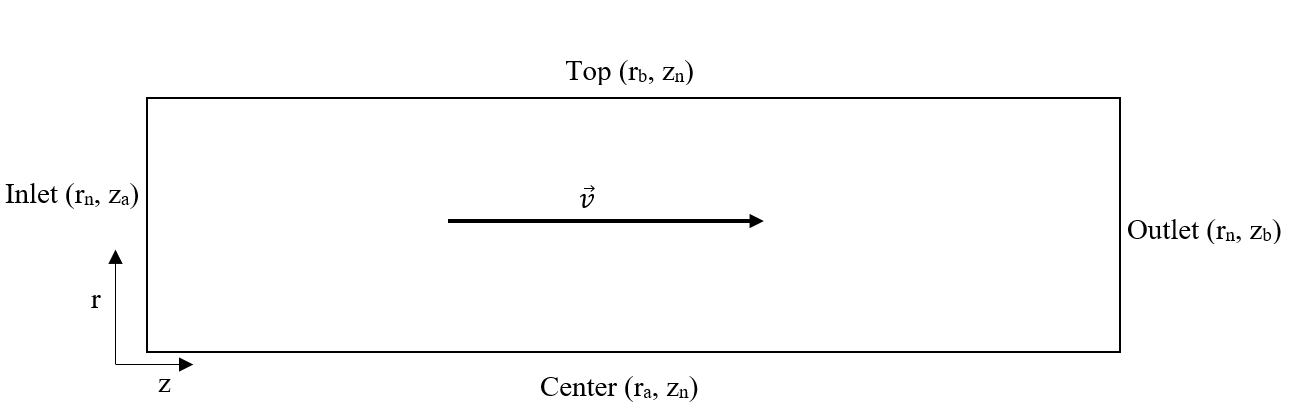

With the following Boundary Conditions \
[**Top**] : $ -q(r_b) = k(u(r)-u_\infty ) $ \
[**Center**] : $ q(r_a) = 0 $ \
[**Inlet**] : $ u(r_n) = a $ 






In [1]:
import os
#os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
#os.environ['DISPLAY'] = ':99'

#import panel as pn
#pn.extension('vtk')



### new cell simple plot ###

In [12]:
### '''Domain'''
def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 150
    radius = 8.75 
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height, radius=radius)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 
    plo.add_mesh(coolant, color='grey', opacity=1.0,)
   
    plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
    plo.set_viewup([0,1,0])
   
    cpos = plo.show(window_size=[800, 600])

In [13]:
show_domain()

Widget(value='<iframe src="http://localhost:53640/index.html?ui=P_0x1e7ab43a4b0_1&reconnect=auto" class="pyvis…

## [Objectives](#toc)<a id="obj"></a>

1. Develop a model for diffusion of Tritium through a Pipe Wall in 1D.
2. Implement the model into MOOSE and attain an understanding for MOOSE CFD Software.
If Time Permits.
3. Extend the Poisson 1D problem to a 2D case without convection.
4. Implement the Galerkin Weak form 2D Poisson convection-diffusion code into the Pipe Wall Diffusion Code.

## [Approach](#toc)<a id="app"></a>

  1. Develop 1-D diffusion Poisson problem.
  2. Determine rate limitng step for the problem.
  3. Implement the diffusion problem into MOOSE using 316SS pipe properties.
  4. Extend Testing into other potential pipe materials.
  5. Extend the problem into 2D without convection if time permits.
  6. Integrate convection-diffusion 2D Poisson Code.

### [Rate Limiting Diffusion Step (Mass Transfer)](#toc)<a id="ratelimiting"></a> 

<br>
Denote the rate limiting step here


### [MOOSE Kernels](#toc)<a id="kernels"></a>

In order to input the weak form of the receding problem statment into MOOSE, it must be written in inner product notation:

\begin{align*} 
( \nabla \varphi  , D \nabla u ) - < \varphi ,D \nabla u \cdot \vec{n} > + ( \varphi , \vec {v} \cdot \nabla u )=0. 
 \end{align*}

 Where, in MOOSE\
$ ( \nabla \varphi \ , \ D \nabla u\ )  = $ Kernel
 
$ < \varphi , D\nabla u\cdot \vec{n} > = $ Boundary Condition 

$ ( \varphi , \vec {v} \cdot \nabla u ) = $ Kernel 
 

Therefore the MOOSE kernels used in this project to solve the [weak form](#weakform) are as followed:


**Diffusion Kernel** : $(\nabla \varphi,D\nabla u)$

 + [DiffusionTerm.h](./include/kernels/X.h) and [DiffusionTerm.C](./src/kernels/X.C)
 
 
**Convection Kernel** : $ ( \varphi,\vec {v} \cdot \nabla u)$

 + [ConvectionTerm.h](./include/kernels/X.h) and [ConvectionTerm.C](./src/kernels/X.C).
 
**Boundary Conditions** : $ <\varphi,D\nabla u\cdot\vec{n}> $ 

[**Top**] - [NormalFluxBC.h](./include/kernels/X.h) and [NormalFluxBC.C](./src/kernels/X.C)
 
$-q(z_n, r_b) = k(u(r)-u_\infty ) $

[**Center**]-  MOOSE implemented NeumannBC 

$ q(z_n, r_a) = 0 $
 
[**Inlet**] - MOOSE implemented DirichletBC

$ u(z_a, r_n) = a $

[**Outlet**] - MOOSE implemented NeumannBC 

$ q(z_b, r_n) = 0 $



### [Setup](#toc)<a id="setup"></a>

In [4]:
'''1-D Domain'''

#z_left = 0 #cm
#z_right =150 #cm
r_bottom=0 #cm
r_top=9.5 #cm

'''Parameters'''
Re=10
diff_coeff = .000266493 #cm2/s
s_source = 0
fluid_density= 1940.8544 #kg/m3
fluid_viscosity=0.00158871 #Pa-s
    
vel=(Re*fluid_viscosity)/(fluid_density*(2*r_top/100))*100
print('velocity of fluid '+ '= ' + str(vel)+ ' cm/s ')

schmidt_number=(fluid_viscosity)/(fluid_density*(diff_coeff/10000))
print('The Schmidt Number of the fluid =  ' + str(schmidt_number))

Sherwood_exp1=0.015*pow(Re,0.83)*pow(schmidt_number,0.42)
print('The Sherwood Number using the expression in the introduction =   ' + str(Sherwood_exp1))

Mass_transfer_coeff=(Sherwood_exp1*diff_coeff)/(2*r_top)
print('The Mass Transfer Coeffient =  ' + str(Mass_transfer_coeff)+'  cm/s')

Peclet_Number=r_top*vel/diff_coeff
print('The Peclet Number of the fluid =  ' + str(Peclet_Number))

velocity of fluid = 0.004308221976335457 cm/s 
The Schmidt Number of the fluid =  30.716085432027736
The Sherwood Number using the expression in the introduction =   0.4273511954100537
The Mass Transfer Coeffient =  5.994005374653234e-06  cm/s
The Peclet Number of the fluid =  153.5804271601387


In [5]:
'''Data (boundary conditions)'''

u_inlet = 3.6e-07 #ug/cc
q_center=0 #ug/cm^2
q_bottom=0 #ug/cm^2
ambient_conc = 0 #ug/cm^2
velocity=[vel,0,0] #cm/s
print(vel)
Mass_transfer_coef= Mass_transfer_coeff #cm/s
print(Mass_transfer_coef)

0.004308221976335457
5.994005374653234e-06


### [Tests](#toc)<a id="tests"></a>

#### [No-Convection](#toc)<a id="noconvection"></a>

In [6]:
!type hit-files\old-files\NoConvection.hit


# J. R. Frye
# Engy-4390 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 23Sep24

# Parameters [cm]
xmin = 0
xmax = 150 
ymin = 0
ymax = 7.5
diff_coeff =  .000266493 #Diffusion of Tritium in Bulk Fluid
source_s = 0
mesh_type=QUAD9
n_felem_x=50
n_felem_y=100

degree=Second
flux_exit = 0   # Tritium is completely removed before leaving outflow
u_inlet = 3.6e-07   #Concentration of Tritium in the bulk fluid at inlet
velocity = '0 0 0' #Velocity of fluid taken from RE 10,000 
flux_center= 0
Mass_transfer_coeff= 0.0023462780080220212
Ambient_conc = 0

[Problem]
  type = FEProblem
   coord_type = RZ
   rz_coord_axis = X  #Revolve around the x axis (y is now radius)
   
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    
	
	
	nx=${replace n_felem_x}
	ny=${replace n_felem_y}
	elem_type=${replace mesh_type}
   
	
  []
[]

In [7]:
'''Plot function for FEM Solution'''

def plot_solution_noconvec(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import math
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
  
    x = np.linspace(0, 7.5, 50)
    y = (3.6e-07)*np.exp((-0.0023462780080220212/.000266493)*x)
    y2 = (3.6e-07)*np.exp((-0.000146/ .000266493)*x)
    ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)
    ax1.plot(x, y,'b*-',label='Exact Solution k/D = 1.38')
    ax1.plot(x, y2,'g*-',label='Exact Solution k/D = .54887')
    ax1.set_xlabel(r'$r$ ', fontsize=18)
    ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center right', fontsize=12)
    ax1.grid(True)

In [8]:
#import pandas as pd
#df = pd.read_csv('out-radial-noconvec_radial-line_0002.csv')

#plot_solution_noconvec(df, dimension='r', title='Radial Plot FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='Exact solution')

In [9]:
#'''Show 2D solution'''

#import pyvista as pv
#poisson = pv.read('out-noconvec_000_0.vtu')

#plo = pv.Plotter()   

#plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')

#plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
#plo.show_bounds()
#plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
#plo.set_viewup([0,1,0])

#cpos = plo.show(window_size=[900, 800])

## [Results and Analysis](#toc)<a id="ranalysis"></a>

In [10]:

'''Plot function for FEM Solution'''

def plot_solution(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
    
    if (radial == dimension):
        ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$r$ ', fontsize=18)
        ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
        
        ax2 = ax1.twinx()
        ax2.plot(df['y'], df['diffFluxU_radius'],'b*-',label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(r)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        
    #Axial plot   
    
    if (axial == dimension):
        ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$z$ [cm]', fontsize=18)
        ax1.set_ylabel(r'$u_h(z)$ [µg/cc]', fontsize=18, color='red')

        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
            
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_axial'],'b*-',label=flux_basis_functions_type)
        
        ax2.set_ylabel(r"$q_h(x)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
      



    plt.title(title, fontsize=20)
  
    plt.show()
    print('')

In [11]:
!type hit-files\old-files\Actual.hit

# J. R. Frye
# Tritium Transport: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Student: James Frye
# Original Student: Anthony Bowers
# Personal Instructor (PI):Dr. Shubash Sharma
# 23Sep24



# Parameters [cm]
xmin = 0
xmax = 150 
ymin = 0
ymax = 7.5
diff_coeff =  .000266493 #Diffusion of Tritium in Bulk Fluid
source_s = 0
mesh_type=QUAD9
n_felem_x=1
n_felem_y=250

degree=Second
flux_exit = 0   # Tritium is completely removed before leaving outflow
u_inlet = 3.6e-07   #Concentration of Tritium in the bulk fluid at inlet
velocity = '5.45 0 0' #Velocity of fluid taken from RE 10,000 
flux_center= 0
Mass_transfer_coeff= 0.002346
Ambient_conc = 0

[Problem]
  type = FEProblem
   coord_type = RZ
   rz_coord_axis = X  #Revolve around the x axis (y is now radius)
   
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    
	
	
	nx=${replace n_felem_x}
	ny=${

## [Conclusions](#toc)<a id="conclusions"></a>

Old Conclusion for 2D Poisson Convection-Diffusion, Diffusion across the pipe is negligble <br>

The results shown, shows the transport of tritium in a pipe. It was assumed that the diffusion in the z direction is to be completely neglectable due to the Peclet Number, ratio of convection to diffusion, being in the order of $10^5$ magnitude. The significance of the convection term relative to diffusion it was best described by changing the RE number from 10,000 to 10. At the higher end of the RE number, the concentration remains constant up until the surface of the pipe is met, where it drops too significantly. Whereas, in applying the lower end of the RE number the concentration drop is more gradual. 
This result makes sense, because under steady state computation we are solving for the point at which flow becomes fully developed. Therefore, the results will be representative of the entrance length and fully developed flow, by the boundary layer. 

Where we must recall that the boundary layer is the layer of fluid in the immediate vicinity of a bounding surface where the effects of viscosity are significant. The boundary layer is described by the Newtonian fluid viscous force profile $F=\mu A \frac{v}{y} $. Since the boundary layer is in terms of velocity, which can be substituted for concentration, the results of u will show the formulation of the boundary layer from entrance length to fully developed. 


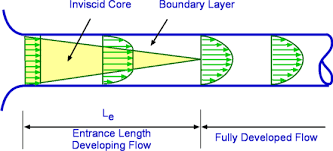

For higher Reynolds number the boundary layer will be less prominate since the viscous force is much greater. Whereas under lower Reynolds number the boundary layer will be more prominate since the viscous force is much less.  


## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5330: Computational Transport Phenomena*](https://github.com/dpploy/engy-5330),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] Stempien D. John, “Tritium Transport, Corrosion, and Fuel Performance Modeling in Fluoride Salt-Cooled High-Temperature Reactor (FHR)”. Massachusetts Institute of Technology. PDF. June 2017
- [4] R. Serrano-Lópeza, J. Fraderaa, S. Cuesta-Lópeza. “Molten salts database for energy applications”. PDF. September 2014.